In [1]:
from cmath import nan
from timeit import repeat
from tkinter import Y

import numpy as np
import skimage
from skimage.io import imread
from skimage.measure import block_reduce
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import pickle
import json
import scipy.io as scio
import pickle
from scipy import signal
from skimage import restoration
import scipy
import statistics

from pathlib import Path

In [2]:
# Absolute path to the JSON file
file_path = Path(r'C:/Users/Conor/2Psinapod/2Psinapod/config_widefield.json')

# Load JSON file
with file_path.open('r') as f:
    config = json.load(f)

In [3]:
BASE_PATH = config['RecordingFolder'] # folder with all of the files required to process recording. 
TIFF_PATH = config['TIFF']
CSV_PATH = config['Triggers'] # name of CSV (assumed to be in the folder given in line above) with the trigger voltages over the recording
CONDITIONS_PATH = config['Conditions'] # name of the CSV (assumed to be in folder given two lines above) with the condition types of each trial (freq, intensity, etc)
TIFF = BASE_PATH + TIFF_PATH

STIMULUS_FRAMERATE = config['TriggerFR'] # framerate of the trigger file
TRIGGER_DELAY_IN_MS = config['TriggerDelay'] # delay between TDT sending a trigger and the stimulus actually happening
RECORDING_FRAMERATE = config['RecordingFR'] # framerate of the fluorescence recording
EPOCH_START_IN_MS = config['EpochStart'] # time to include before trial onset for each epoch
EPOCH_END_IN_MS = config['EpochEnd'] # time to include after trial onset for each epoch
NO_BASELINE_FRAMES = config['BaselineFrames']
ZSCORE_THRESHOLD = config['ZscoreThreshold']
START = config['ResponseStart']
STOP = config['ResponseStop']

In [4]:
def get_onset_frames(stimulus):
    # find the max voltage (this will be the value in the vector when the trigger was sent)
    max_voltage = max(stimulus, key=lambda x:x[1])
    max_voltage = max_voltage[1]

    onset_times = [] # empty list to append our onset frames into
    time_list_index = 0 # counter to keep track of our index in the onset_times list

    # for each frame in the stimulus file
    for stimulus_idx in range(len(stimulus)):
        (time,voltage) = stimulus[stimulus_idx] # unpack the voltage at that timepoint

        if voltage.round() == max_voltage.round(): # if the voltage was our trigger voltage
            if time_list_index == 0: # and if we're at the first index (so there's no previous index to compare with)
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # add the time as an onset time in SECONDS
                time_list_index += 1

            # if we're not at index zero, we need to compare this voltage with the previous saved onset voltage
            # otherwise we save a bunch of voltages as separate triggers because they all match the max voltage
            # but we just want one timepoint per trigger
            elif time/1000 -  onset_times[time_list_index - 1] > 1: 
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # want it in second not millisecond
                time_list_index += 1

    # get the onset times in terms of frames of our fluorescence trace
    onset_frames_at_recording_fr = np.multiply(onset_times,RECORDING_FRAMERATE) # s * f/s = f

    #Remove first three triggers, corresponding to start at frame zero, 
    onset_frames_at_recording_fr = onset_frames_at_recording_fr[3:]

    return onset_frames_at_recording_fr

In [5]:
def get_max_dict(freq_dict):   

    max_dict = dict.fromkeys(np.unique(conditions[:,0])) 
    
    for freq in freq_dict:

        freq_array = np.empty([len(freq_dict[freq]),25,256,256])

        for rep in range(1,len(freq_dict[freq])):
            freq_array[rep-1,:,:,:] = freq_dict[freq][rep]
        
        avg_array = np.mean(freq_array,axis=0)
        stim_periods = avg_array[START:STOP,:,:]
        max_array = np.max(stim_periods,axis=0)

        max_dict[freq] = max_array
    
    return max_dict

In [10]:
def threshold_responses(median_zscore_dict):
    thresholded_dict = {key : np.clip(median_zscore_dict[key],a_min=ZSCORE_THRESHOLD,a_max=None) for key in median_zscore_dict}
    return thresholded_dict

In [9]:
# For each pixel, return the value from across all frequencies that was the maximum response. 
def get_best_frequency(thresholded_dict):

        array_list = []
        for freq in thresholded_dict:
                array_list.append(list(thresholded_dict[freq]))

        max_array = np.array(array_list)
        best_freq = np.empty(shape=[1,256,256])
        for i in range(len(max_array[0,:,0])):
                for j in range(len(max_array[0,0,:])):
                        indices = np.where(max_array[:,i,j] == max_array[:,i,j].max())
                        indices = np.array(indices[0])
                        if len(indices) == 1:
                                best_freq[:,i,j] = indices
                        else:
                                best_freq[:,i,j] = float('nan')

        return best_freq

In [8]:
def plot(median_zscore_dict):

        threshold = {key : np.clip(median_zscore_dict[key],a_min=ZSCORE_THRESHOLD,a_max=None) for key in median_zscore_dict}
        rounded = {key : np.around(threshold[key], 1) for key in threshold}

        fig,axes = plt.subplots(nrows=3, ncols=4, constrained_layout=True)
        axes = axes.ravel()
        for i, (key, value) in enumerate(rounded.items()):
                axes[i].imshow(np.squeeze(value))
                axes[i].title.set_text(key)
        plt.suptitle('Median Amplitude, ' + str(TIFF_PATH[:20]) + ' Response Frame = ' + str(START) + ':' + str(STOP) + 
        ' ZscoreThreshold = ' + str(ZSCORE_THRESHOLD))
        plt.show()
        return fig,axes

In [6]:
FILEPATH = "L:/widefield/ID543_saline/Day 1/ID543_24042024_GCaMP6s_1/"

with open(FILEPATH+"zscore_dict.pkl", 'rb') as f:
    zscore_dict = pickle.load(f)

In [11]:
stimulus = np.genfromtxt(BASE_PATH + CSV_PATH,delimiter=',',skip_header=True) # voltage values of the trigger software over the recording
conditions_mat = scio.loadmat(BASE_PATH + CONDITIONS_PATH) # conditition type of each trial in chronological order
conditions = conditions_mat["stim_data"]
conditions = conditions[3:]  #Remove the first silent stim as this corresponds to frame 0

onset_frames = np.round(get_onset_frames(stimulus))


max_dict = get_max_dict(zscore_dict)

# # Normalize the individual frequency so that they are z-scored relative to all of the pixels for that frequency. 
# # This irons out potential bias in the map from the entire cortex being more responsive to particular frequency ranges. 
for key,value in max_dict.items():
    max_dict[key] = scipy.stats.zscore((np.squeeze(value)),axis=None)

thresholded_dict = threshold_responses(max_dict)

best_freq = get_best_frequency(thresholded_dict)

best_freq = np.squeeze(best_freq)

total_pixels = best_freq.shape[0] * best_freq.shape[1]
print(total_pixels)
active_pixels = np.count_nonzero(~np.isnan(best_freq))
print(active_pixels)

65536
20890


In [12]:
active_pixels_by_freq = np.empty([len(thresholded_dict.keys())])

for i, freq in zip(range(active_pixels_by_freq.shape[0]),thresholded_dict.keys()):
    mask = np.where(thresholded_dict[freq] > 2)
    active_pixels_by_freq[i] = np.count_nonzero(mask)


active_percentages = (active_pixels_by_freq / active_pixels) * 100
print(active_percentages)


[36.17041647 38.8128291  36.80229775 34.90186692 35.2321685  35.95978937
 33.49928195 31.58449019 33.91096218 37.76926759 33.94925802 30.10052657]


In [13]:
BF_by_freq = np.empty([len(thresholded_dict.keys())])
BF_total_count = np.count_nonzero(~np.isnan(best_freq))

for i in range(len(thresholded_dict.keys())):
    mask = np.where(best_freq == int(i))
    BF_by_freq[i] = np.count_nonzero(mask)

percent_of_total = (BF_by_freq / BF_total_count) * 100
print(BF_by_freq)
print("The number of active pixels is:", BF_total_count)
print(percent_of_total)

[3822. 4522. 3840. 2870. 2190. 3432. 3264. 2562. 2746. 4564. 2915. 5041.]
The number of active pixels is: 20890
[18.29583533 21.64672092 18.38200096 13.73863092 10.48348492 16.42891336
 15.62470081 12.26424126 13.14504548 21.84777405 13.954045   24.13116324]


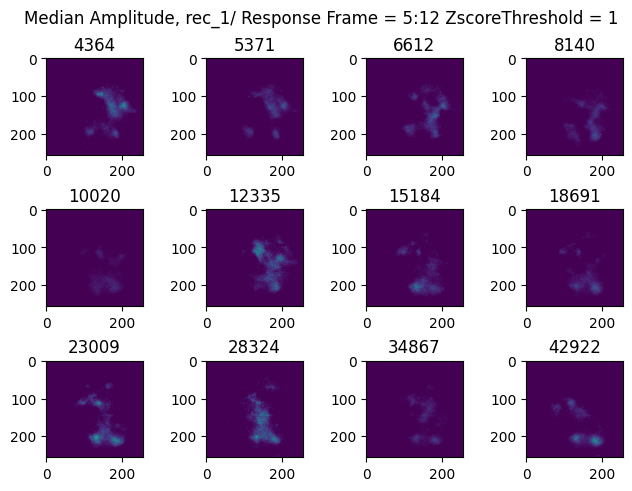

(<Figure size 640x480 with 12 Axes>,
 array([<AxesSubplot:title={'center':'4364'}>,
        <AxesSubplot:title={'center':'5371'}>,
        <AxesSubplot:title={'center':'6612'}>,
        <AxesSubplot:title={'center':'8140'}>,
        <AxesSubplot:title={'center':'10020'}>,
        <AxesSubplot:title={'center':'12335'}>,
        <AxesSubplot:title={'center':'15184'}>,
        <AxesSubplot:title={'center':'18691'}>,
        <AxesSubplot:title={'center':'23009'}>,
        <AxesSubplot:title={'center':'28324'}>,
        <AxesSubplot:title={'center':'34867'}>,
        <AxesSubplot:title={'center':'42922'}>], dtype=object))

In [14]:
plot(max_dict)

Text(0, 0.5, 'Count')

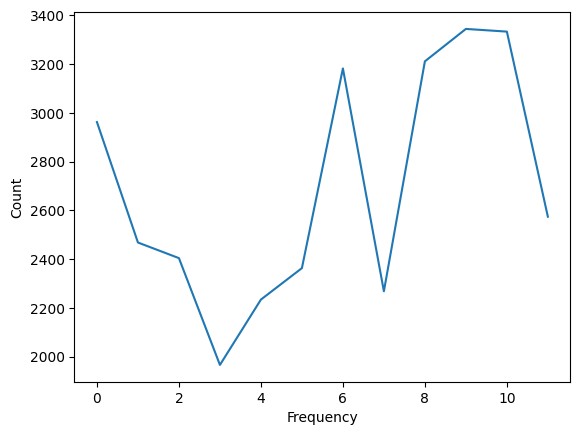

In [ ]:
plt.plot(BF_by_freq)
plt.xlabel("Frequency")
plt.ylabel("Count")

Text(0, 0.5, 'percent of total')

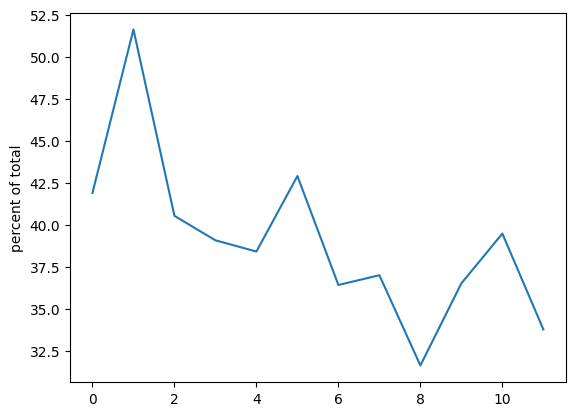

In [ ]:
plt.plot(active_percentages)
plt.ylabel("percent of total")

In [ ]:
# print(max_dict.keys())

dict_keys([4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922])


In [ ]:
# # Specify the path to your CSV file
# csv_file_path = "L:/widefield/percent_saline_1.csv"

# # Load the CSV file into a NumPy array
# percent_saline_1 = np.loadtxt(csv_file_path, delimiter=',')

In [ ]:
# # Specify the path to your CSV file
# csv_file_path = "L:/widefield/percent_saline_6.csv"

# # Load the CSV file into a NumPy array
# percent_saline_6 = np.loadtxt(csv_file_path, delimiter=',')

In [ ]:
# # Specify the path to your CSV file
# csv_file_path = "L:/widefield/percent_psilocybin_1.csv"

# # Load the CSV file into a NumPy array
# percent_psilo_1 = np.loadtxt(csv_file_path, delimiter=',')

In [ ]:
# # Specify the path to your CSV file
# csv_file_path = "L:/widefield/percent_psilocybin_6.csv"

# # Load the CSV file into a NumPy array
# percent_psilo_6 = np.loadtxt(csv_file_path, delimiter=',')

In [ ]:
# # Specify the path to your CSV file
# csv_file_path = "L:/widefield/percent_psilocybin_14.csv"

# # Load the CSV file into a NumPy array
# percent_psilo_14 = np.loadtxt(csv_file_path, delimiter=',')

In [ ]:
# # Specify the path to your CSV file
# csv_file_path = "L:/widefield/percent_saline_14.csv"

# # Load the CSV file into a NumPy array
# percent_saline_14 = np.loadtxt(csv_file_path, delimiter=',')

In [ ]:
print(percent_saline_1.shape)
print(percent_psilo_1.shape)

(9, 12)
(9, 12)


In [ ]:
# means_saline_1 = np.zeros_like(percent_saline_1[0,:])

# for i in range(len(means_saline_1)):
#     means_saline_1[i] = np.mean(percent_saline_1[:,i])

# print(means_saline_1)

# SE_saline_1 = np.zeros_like(percent_saline_1[0,:])

# for i in range(len(means_saline_1)):
#     SE_saline_1[i] = scipy.stats.sem(percent_saline_1[:,i])

# print(SE_saline_1)

[30.5164152  31.21622422 27.95917    30.08962395 28.37382008 27.39226491
 31.86204761 29.57540784 27.9964295  29.69166057 29.21828823 27.45044736]
[1.75026685 1.62027672 1.23211153 1.30997064 1.25796998 2.0686025
 1.24776576 0.77126767 0.87249369 2.04417401 1.21288721 1.31926842]


In [ ]:


# means_psilo_1 = np.zeros_like(percent_psilo_1[0,:])

# for i in range(len(means_psilo_1)):
#     means_psilo_1[i] = np.mean(percent_psilo_1[:,i])

# print(means_psilo_1)

# SE_psilo_1 = np.zeros_like(percent_psilo_1[0,:])

# for i in range(len(means_psilo_1)):
#     SE_psilo_1[i] = scipy.stats.sem(percent_psilo_1[:,i])

# print(SE_psilo_1)

[26.60409797 28.12010458 25.94053832 25.0526675  24.58062105 25.06232463
 25.70740832 25.31554238 20.2865468  23.86281756 24.73115567 26.88829365]
[0.73398731 1.68071778 1.03932931 0.71666594 1.77701802 1.00767792
 1.35132167 0.82550573 2.55652723 1.3789034  2.55245528 1.61581534]


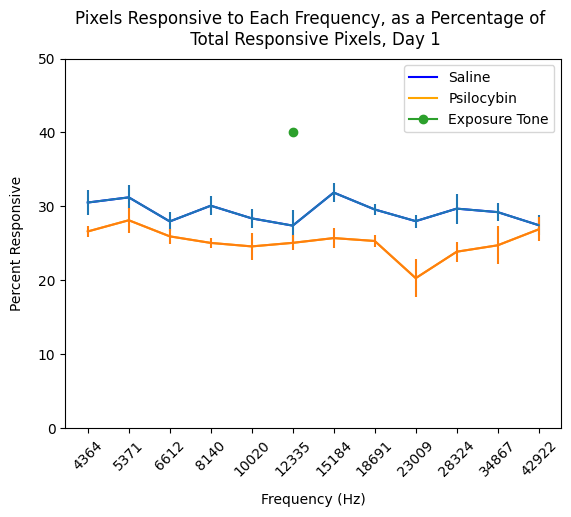

In [ ]:
# x = np.arange(0,12,1)
# ticks = list(max_dict.keys())

# plt.plot(means_saline_1,label='Saline',color='b')
# plt.plot(means_psilo_1,label='Psilocybin',color='orange')
# plt.errorbar(x,means_saline_1,yerr=SE_saline_1)
# plt.errorbar(x,means_psilo_1,yerr=SE_psilo_1)
# plt.xticks(x,ticks,rotation=45)
# plt.ylim(0,50)
# plt.ylabel("Percent Responsive",labelpad=10)
# plt.xlabel("Frequency (Hz)",labelpad=10)
# plt.title("Pixels Responsive to Each Frequency, as a Percentage of \n Total Responsive Pixels, Day 1",pad=10)
# plt.plot(5,40, marker = 'o',label='Exposure Tone')
# plt.legend()


In [ ]:
scipy.stats.mannwhitneyu(percent_saline_1[:,4],percent_psilo_1[:,4])

MannwhitneyuResult(statistic=60.0, pvalue=0.0933976745287926)

In [ ]:
means_saline_6 = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_6)):
    means_saline_6[i] = np.mean(percent_saline_6[:,i])

print(means_saline_6)

SE_saline_6 = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_6)):
    SE_saline_6[i] = scipy.stats.sem(percent_saline_6[:,i])

print(SE_saline_6)

[27.26818158 27.57052321 27.53957912 22.26983748 21.54425352 28.58542632
 24.93797668 23.2863822  22.0725804  24.33327027 24.03545831 24.64379239]
[1.43829337 1.13485334 1.82689649 3.18127354 2.52857706 1.73034507
 2.7291124  2.96543733 3.32769895 2.03117522 2.29309796 1.54920935]


In [ ]:
means_psilo_6 = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_psilo_6)):
    means_psilo_6[i] = np.mean(percent_psilo_6[:,i])

print(means_psilo_6)

SE_psilo_6 = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_psilo_6)):
    SE_psilo_6[i] = scipy.stats.sem(percent_psilo_6[:,i])

print(SE_psilo_6)

[26.081614   24.99212897 25.52428996 25.31273668 24.69195464 27.26274959
 27.15610994 27.8788503  25.31711761 26.3440099  26.67383137 25.34100922]
[1.06881151 1.08816297 1.37708378 1.11425738 1.31741491 1.86800658
 1.05104906 1.44642153 1.35130409 1.31509323 1.64708284 0.90185788]


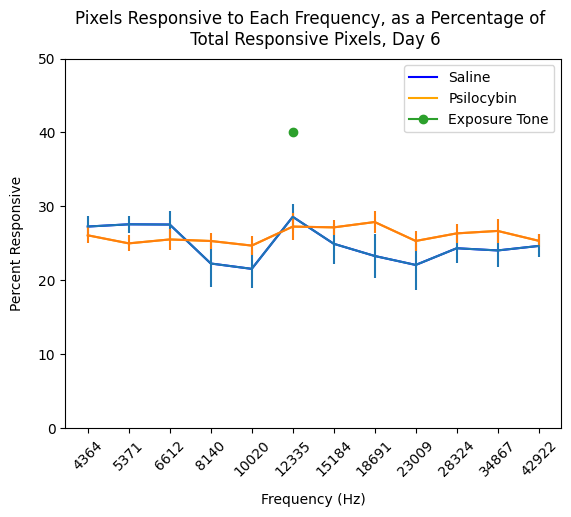

In [ ]:
x = np.arange(0,12,1)
ticks = list(max_dict.keys())

plt.plot(means_saline_6,label='Saline',color='b')
plt.plot(means_psilo_6,label='Psilocybin',color='orange')
plt.errorbar(x,means_saline_6,yerr=SE_saline_6)
plt.errorbar(x,means_psilo_6,yerr=SE_psilo_6)
plt.xticks(x,ticks,rotation=45)
plt.ylim(0,50)
plt.ylabel("Percent Responsive",labelpad=10)
plt.xlabel("Frequency (Hz)",labelpad=10)
plt.title("Pixels Responsive to Each Frequency, as a Percentage of \n Total Responsive Pixels, Day 6",pad=10)
plt.plot(5,40, marker = 'o',label='Exposure Tone')
plt.legend()

In [ ]:
saline_diffs = percent_saline_6 - percent_saline_1
psilo_diffs = percent_psilo_6 - percent_psilo_1

print(saline_diffs)

[[ -7.49599735   2.18890771  -6.53278432  -7.16786512  -0.7924155
   -3.13072577  -4.7030666   -9.82312046  -7.20808759 -20.01468452
   -9.30858635  -2.52561772]
 [ -2.80339089   3.82084452  -0.63969209  -6.11478372  -6.16524805
    9.90537847  -2.6433752   -2.07289911   5.26248145   5.25056319
    3.47914095   6.25807143]
 [ -4.69096962  -4.66017102   4.19495575 -29.10773034 -21.80921334
   -4.68137686 -23.22946488 -25.07374312 -30.38382095  -6.39156469
  -15.44526665 -11.16380578]
 [  2.34059775  -5.00728857   4.3488143   -2.83705026  -1.05671081
    6.63439083   1.01394559   3.89419772  -2.27578229  -1.1239756
   -1.53682775   0.20162246]
 [  2.73365981  -5.2257861   -0.22717007  -5.02874032  -6.93676912
   -1.10525169  -1.27782721  -6.93704771  -5.84131002  -3.73105936
   -5.20622014   1.48423566]
 [ -8.41998762  -9.76411371  -6.73544688  -3.23196313 -11.1775857
   -2.46783448 -10.1175126   -6.33925025   0.73394288  -8.32475487
    1.26177185  -8.93668489]
 [ -6.14911982  -7.483724

In [ ]:
means_saline_diff = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_diff)):
    means_saline_diff[i] = np.mean(saline_diffs[:,i])

print(means_saline_diff)

SE_saline_diff = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_6)):
    SE_saline_diff[i] = scipy.stats.sem(saline_diffs[:,i])

print(SE_saline_diff)

[-3.24823362 -3.64570101 -0.41959088 -7.81978647 -6.82956656  1.19316141
 -6.92407093 -6.28902564 -5.9238491  -5.3583903  -5.18282992 -2.80665497]
[1.59092742 1.75602018 1.75671165 3.01665168 2.1858154  1.69790459
 2.39391066 2.89460473 3.43060779 2.31114271 2.00640549 1.82206761]


In [ ]:
means_psilo_diff = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_diff)):
    means_psilo_diff[i] = np.mean(psilo_diffs[:,i])

print(means_psilo_diff)

SE_psilo_diff = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_saline_6)):
    SE_psilo_diff[i] = scipy.stats.sem(psilo_diffs[:,i])

print(SE_psilo_diff)

[-0.52248397 -3.12797561 -0.41624836  0.26006918  0.11133359  2.20042496
  1.44870162  2.56330792  5.03057081  2.48119234  1.9426757  -1.54728443]
[1.02725418 1.65148138 1.36183503 0.98690046 2.75390088 2.33910826
 1.14251236 1.50260099 3.32991752 1.99590748 3.91331133 1.88895969]


(-30.0, 30.0)

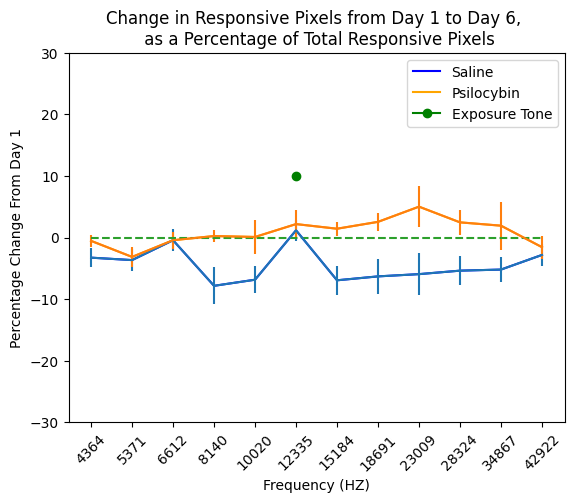

In [ ]:
plt.plot(means_saline_diff,color='b',label='Saline')
plt.plot(means_psilo_diff,color='orange',label='Psilocybin')
plt.errorbar(x,means_saline_diff,yerr=SE_saline_diff)
plt.errorbar(x,means_psilo_diff,yerr=SE_psilo_diff)
plt.xticks(x,ticks,rotation=45)
plt.ylabel("Percentage Change From Day 1")
plt.xlabel("Frequency (HZ)")
plt.title("Change in Responsive Pixels from Day 1 to Day 6, \n as a Percentage of Total Responsive Pixels")
plt.plot([np.min(x), np.max(x)], [0]*2, '--')
plt.plot(5,10, marker = 'o',label='Exposure Tone',color='g')
plt.legend()

plt.ylim(-30,30)

In [ ]:
scipy.stats.mannwhitneyu(saline_diffs[:,8],psilo_diffs[:,8])

MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)

In [ ]:
result = scipy.stats.ttest_ind(saline_diffs[:,7],psilo_diffs[:,7])
print(result)

Ttest_indResult(statistic=-2.714297539547632, pvalue=0.015316606308127404)


In [ ]:
print(percent_psilo_1.shape)

(9, 12)


In [ ]:
percent_saline_1_norm  = percent_saline_1 / np.sum(percent_saline_1, axis=1, keepdims=True)
percent_psilo_1_norm  = percent_psilo_1 / np.sum(percent_psilo_1, axis=1, keepdims=True)

In [ ]:
print(np.sum(percent_saline_1_norm[:,0]))

0.7773338702544073


In [ ]:
percent_saline_6_norm  = percent_saline_6 / np.sum(percent_saline_6, axis=1, keepdims=True)
percent_psilo_6_norm  = percent_psilo_6 / np.sum(percent_psilo_6, axis=1, keepdims=True)

In [ ]:
diff_saline_norm = percent_saline_6_norm - percent_saline_1_norm
diff_psilo_norm = percent_psilo_6_norm - percent_psilo_1_norm


In [ ]:
means_psilo_diff_norm = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_diff)):
    means_psilo_diff_norm[i] = np.median(diff_psilo_norm[:,i])

print(diff_psilo_norm)

SE_psilo_diff_norm = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_saline_6)):
    SE_psilo_diff_norm[i] = scipy.stats.sem(diff_psilo_norm[:,i])

print(SE_psilo_diff_norm)

[[-0.00550452 -0.04186018  0.00198636 -0.01759647 -0.00372338  0.01206166
   0.00646573  0.02201553  0.0172085  -0.00493921 -0.00525616  0.01914214]
 [-0.00482128 -0.00240455 -0.0133172   0.00178764 -0.0016302   0.0003274
   0.0085929  -0.01838627  0.01408477  0.03124625 -0.0005483  -0.01493117]
 [-0.01727252 -0.03358498  0.01342244 -0.00375963  0.01099829  0.00444684
   0.00308379  0.01407286  0.01695622  0.00916969 -0.01135209 -0.00618091]
 [ 0.00439608  0.01492437  0.01418415  0.00080894 -0.01212281  0.02692486
   0.00350351  0.00271367  0.0142338  -0.01943902 -0.03176357 -0.018364  ]
 [-0.021905   -0.03469021 -0.02607987 -0.02002531  0.02662199  0.01347573
  -0.03053653 -0.00629759  0.07187062  0.00814757  0.06781034 -0.04839174]
 [-0.00394756  0.0074419  -0.00099036  0.00296061 -0.01362036 -0.00958871
   0.010581    0.00692735  0.00639451  0.01727736 -0.01738029 -0.00605546]
 [ 0.00543579 -0.01166833 -0.0158184   0.0056565  -0.00389444 -0.00254224
   0.0167275   0.0046207  -0.0032

In [ ]:
means_saline_diff_norm = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_diff)):
    means_saline_diff_norm[i] = np.median(diff_saline_norm[:,i])

print(diff_saline_norm)

SE_saline_diff_norm = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_saline_6)):
    SE_saline_diff_norm[i] = scipy.stats.sem(diff_saline_norm[:,i])

print(SE_saline_diff_norm)

[[-0.00289737  0.0338496  -0.00277752 -0.00235672  0.02193558  0.00792029
   0.00698086 -0.01209294 -0.00380361 -0.04925753 -0.01206272  0.01456208]
 [-0.01074321  0.00742243 -0.00444491 -0.020395   -0.02030607  0.0244144
  -0.0104944  -0.00867088  0.01129335  0.01126489  0.00639541  0.01426399]
 [ 0.06298541  0.05441667  0.09210948 -0.07934612 -0.0518052   0.06368477
  -0.04758982 -0.05751651 -0.08287554  0.04102045 -0.01244137  0.01735778]
 [ 0.0069112  -0.01849531  0.01361591 -0.01100936 -0.00503344  0.02164887
   0.00192872  0.01191266 -0.00913178 -0.00492223 -0.00665443 -0.00077082]
 [ 0.01906311 -0.00491262  0.00960798 -0.00630263 -0.01313334  0.00769273
   0.00740781 -0.01270371 -0.01069878 -0.0029815  -0.00524198  0.01220296]
 [-0.00474164 -0.00868523 -0.00103047  0.00877325 -0.01619298  0.01014998
  -0.01330861 -0.00256176  0.01957222 -0.00434842  0.02148606 -0.00911241]
 [ 0.00411296  0.00226916 -0.00132491 -0.02716991 -0.00038836  0.02815796
  -0.01062329 -0.00653424 -0.0134

(-0.05, 0.05)

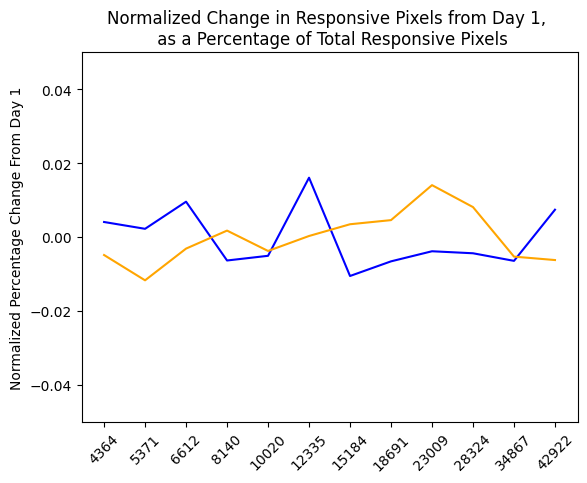

In [ ]:
plt.plot(means_saline_diff_norm,color='b',label='Saline')
plt.plot(means_psilo_diff_norm,color='orange',label='Psilocybin')

plt.xticks(x,ticks,rotation=45)
plt.ylabel("Normalized Percentage Change From Day 1")
plt.title("Normalized Change in Responsive Pixels from Day 1, \n as a Percentage of Total Responsive Pixels")
plt.ylim(-0.050,0.050)


In [ ]:
mean_rawnorm_saline = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_diff)):
    mean_rawnorm_saline[i] = np.median(percent_saline_6_norm[:,i])

print(mean_rawnorm_saline)

SE_saline_rawnorm = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_saline_6)):
    SE_saline_rawnorm[i] = scipy.stats.sem(percent_saline_6_norm[:,i])

print(SE_saline_rawnorm)

[0.08851507 0.08688291 0.09053125 0.0783908  0.0748122  0.08957029
 0.08598555 0.07917542 0.07871875 0.08384617 0.08000368 0.08183064]
[0.00852242 0.00674739 0.00969529 0.00894611 0.00748884 0.00838436
 0.00706329 0.00724914 0.00924499 0.00611007 0.00417691 0.00339751]


In [ ]:
mean_rawnorm_psilo = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_saline_diff)):
    mean_rawnorm_psilo[i] = np.median(percent_psilo_6_norm[:,i])

print(mean_rawnorm_psilo)

SE_psilo_rawnorm = np.zeros_like(percent_psilo_6[0,:])

for i in range(len(means_saline_6)):
    SE_psilo_rawnorm[i] = scipy.stats.sem(percent_psilo_6_norm[:,i])

print(SE_psilo_rawnorm)

[0.08667958 0.08054885 0.08186001 0.08322939 0.07771588 0.08461376
 0.08582123 0.08944099 0.0818343  0.08603105 0.08334275 0.0796933 ]
[0.00249566 0.00326352 0.00411064 0.00235979 0.00220981 0.00357226
 0.00332306 0.00339682 0.00322739 0.0038106  0.00389841 0.00271558]


(0.05, 0.15)

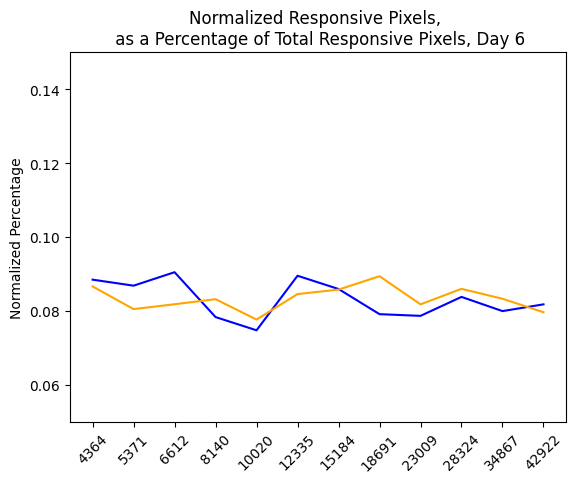

In [ ]:
plt.plot(mean_rawnorm_saline,color='b',label='Saline')
plt.plot(mean_rawnorm_psilo,color='orange',label='Psilocybin')

plt.xticks(x,ticks,rotation=45)
plt.ylabel("Normalized Percentage")
plt.title("Normalized Responsive Pixels, \n as a Percentage of Total Responsive Pixels, Day 6")
plt.plot([np.min(x), np.max(x)], [0]*2, '--')
plt.ylim(0.05,0.15)


In [ ]:
saline_diffs_14 = percent_saline_14 - percent_saline_1
psilo_diffs_14 = percent_psilo_14 - percent_psilo_1

In [ ]:
means_psilo_diff_14 = np.zeros_like(percent_saline_6[0,:])

for i in range(len(means_psilo_diff_14)):
    means_psilo_diff_14[i] = np.mean(psilo_diffs_14[:,i])

print(means_psilo_diff_14)

SE_psilo_diff_14 = np.zeros_like(percent_psilo_14[0,:])

for i in range(len(psilo_diffs_14)):
    SE_psilo_diff_14[i] = scipy.stats.sem(psilo_diffs_14[:,i])

print(SE_psilo_diff_14)

[-6.00709487 -4.29289307 -2.46971215 -3.40067603 -0.96970042 -1.41788405
 -3.67964424 -2.60898175  0.31440265 -1.90892233 -1.15243399 -3.7226024 ]
[2.57347428 2.08661308 3.10996501 4.01127507 3.6835659  2.30874967
 1.99705883 1.8930991  4.54398699 0.         0.         0.        ]


In [ ]:
means_saline_diff_14 = np.zeros_like(percent_saline_14[0,:])

for i in range(len(means_saline_diff_14)):
    means_saline_diff_14[i] = np.mean(saline_diffs_14[:,i])

print(means_saline_diff_14)

SE_saline_diff_14 = np.zeros_like(percent_saline_14[0,:])

for i in range(len(means_saline_diff_14)):
    SE_saline_diff_14[i] = scipy.stats.sem(saline_diffs_14[:,i])

print(SE_saline_diff_14)

[-4.11231054 -4.21658991 -2.39260673 -4.46867156 -4.30366943  0.22614177
 -5.60658706 -3.55171029 -3.97321633 -5.87335282 -6.90065565 -3.35735622]
[1.41929394 1.51184753 1.76148263 1.09662949 1.72704633 2.28095886
 1.33131718 0.85092884 0.88453106 2.14357452 1.74931138 1.49896799]


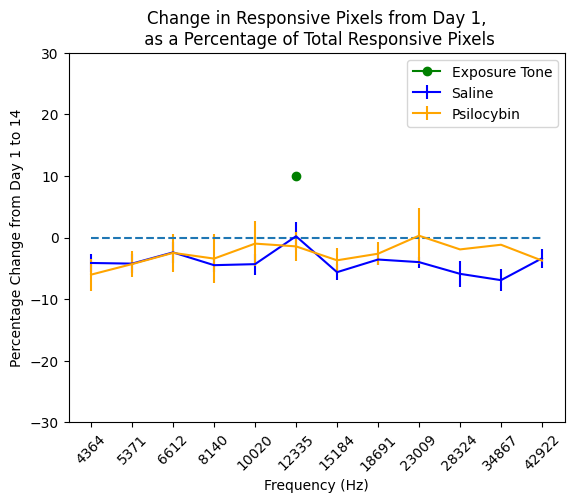

In [ ]:
x = np.arange(0,12,1)
ticks = list(max_dict.keys())
# Plot data with error bars
plt.errorbar(x, means_saline_diff_14, yerr=SE_saline_diff_14, color='b', label='Saline')
plt.errorbar(x, means_psilo_diff_14, yerr=SE_psilo_diff_14, color='orange', label='Psilocybin')

# Plot the exposure tone point
plt.plot(5, 10, marker='o', label='Exposure Tone', color='g')  # Use plt.plot() for a single point

# Customize the plot
plt.xticks(x, ticks, rotation=45)
plt.ylabel("Percentage Change from Day 1 to 14")
plt.xlabel("Frequency (Hz)")
plt.plot([np.min(x), np.max(x)], [0]*2, '--')  # Plot horizontal line at y=0
plt.ylim(-30, 30)
plt.legend()
plt.title("Change in Responsive Pixels from Day 1,\n as a Percentage of Total Responsive Pixels")

# Show the plot
plt.show()

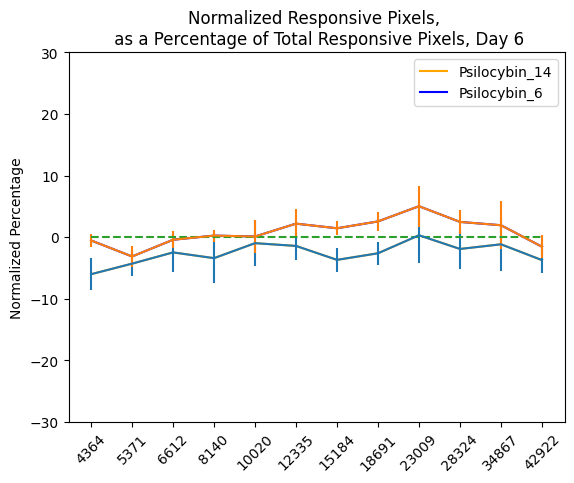

In [ ]:

plt.plot(means_psilo_diff_14,color='orange',label='Psilocybin_14')
plt.plot(means_psilo_diff,color='b',label='Psilocybin_6')
plt.xticks(x,ticks,rotation=45)
plt.ylabel("Normalized Percentage")
plt.title("Normalized Responsive Pixels, \n as a Percentage of Total Responsive Pixels, Day 6")
plt.errorbar(x,means_psilo_diff_14,yerr=SE_psilo_diff_14)
plt.errorbar(x,means_psilo_diff,yerr=SE_psilo_diff)
plt.plot([np.min(x), np.max(x)], [0]*2, '--')
plt.ylim(-30,30)
plt.legend()


(-30.0, 30.0)

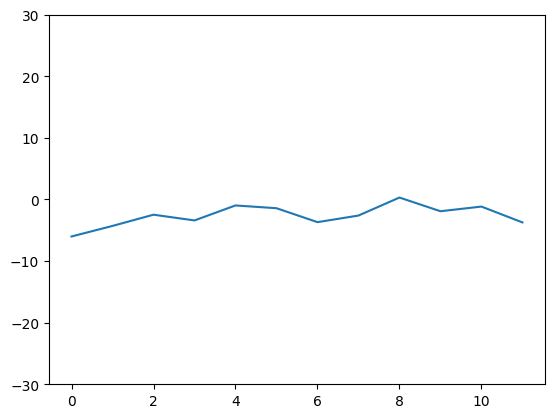

In [ ]:
plt.plot(means_psilo_diff_14)
plt.ylim(-30,30)